# Creating an Agent for Bedrock via APIs: Creating agents, action groups, associating knowledge bases, and invoking the agent to query from the KB

In [2]:
#install knowledge base sdk
%pip install --upgrade pip
%pip install boto3 --force-reinstall
%pip install botocore --force-reinstall
%pip install botocore --force-reinstall
%pip install langchain --force-reinstall --quiet

Note: you may need to restart the kernel to use updated packages.
  Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
  Using cached s3transfer-0.8.2-py3-none-any.whl.metadata (1.8 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached urllib3-2.0.7-py3-none-any.whl.metadata (6.6 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 36.8 MB/s eta 0:00:00:00:010:01
Using cached s3transfer-0.8.2-py3-none-any.whl (82 kB)
Using cached urllib3-2.0.7-py3-none-any.whl (124 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: jmespath
    Fou

#### Restart the kernel with the updated packages that are installed through the dependencies above

In [3]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
import nest_asyncio
nest_asyncio.apply()

### Follow the steps below to initiate hte bedrock client:

1. Import the necessary libraries, along with langchain for bedrock model selection, llama index to store the service context containing the llm and embedding model instances.

2. Use langchain to import bedrock embeddings and llama index for langchain embeddings

3. Configure the bedrock-runtime and the bedrock-agent-runtime to be able to initiate execution with the knowledge base associated to your account toe perform RAG and model evaluation using llama index.

4. Use the amazon.titan-embed-text-v1 as our embeddings model for chunk enbeddings during the RAG performance on user queries.

5. Initialize 'anthropic.claude-v2' as our large language model to perform query completions on using the RAG with the given knowledge base, once we get all vector searches through the retrieve API.

In [5]:


import boto3
import pprint
from botocore.client import Config
from langchain.llms.bedrock import Bedrock
from llama_index import (
    ServiceContext,
    set_global_service_context
)
from langchain.embeddings.bedrock import BedrockEmbeddings
from llama_index.embeddings import LangchainEmbedding

pp = pprint.PrettyPrinter(indent=2)



bedrock_config = Config(connect_timeout=120, read_timeout=120, retries={'max_attempts': 0})
bedrock_client = boto3.client('bedrock-runtime')
bedrock_agent_client = boto3.client("bedrock-agent-runtime",
                              # endpoint_url=endpoint_url,
                              region_name='us-east-1',
                              config=bedrock_config)
                              # aws_access_key_id=ACCESS_KEY,
                              # aws_secret_access_key=SECRET_KEY)

model_kwargs_claude = {
    "temperature": 0,
    "top_k": 10,
    "max_tokens_to_sample": 3000
}

embed_model = LangchainEmbedding(
    BedrockEmbeddings(model_id="amazon.titan-embed-text-v1")
)

llm = Bedrock(model_id="anthropic.claude-v2",
              model_kwargs=model_kwargs_claude,
              client = bedrock_client,)

service_context = ServiceContext.from_defaults(llm=llm,
                                               embed_model=embed_model)
set_global_service_context(service_context)

### Set Logger for logging purposes

In [7]:
import uuid
import boto3
import pprint
import botocore
import logging
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [8]:
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [9]:
# create an boto3 bedrock agent client
ENDPOINT_URL: str = None
client = boto3.client("bedrock-agent", endpoint_url=ENDPOINT_URL)
logger.info(client)

[2023-12-04 21:42:00,676] p4194 {1614525550.py:4} INFO - <botocore.client.AgentsforBedrock object at 0x7f05b5b122f0>


### Now, we will use this client to create an agent via the API 'create-agent'

In [11]:
response=client.create_agent(
    agentName="test-Agent",
    agentResourceRoleArn="arn:aws:iam::accountid:role/rolename",
    description="Agent for handling tests for testing",
    idleSessionTTLInSeconds=1800,
    foundationModel="anthropic.claude-v2",
    instruction="You are a test agent that interacts with the knowledge base to provide accurate responses to user questions.",
)

### Now, print out the response to check the status of the agent we created via the API:

In [44]:
response

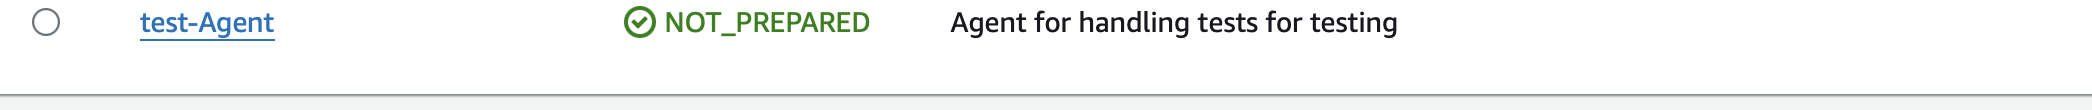



### More details on the agent created: AgentID, creating an action group, etc

In [45]:
agent_id = response['agent']['agentId']
agent_id

In [17]:
## Now, we can configure and create an action group here:

agent_action_group_response = client.create_agent_action_group(
    agentId=agent_id,
    agentVersion='DRAFT',
    actionGroupExecutor={
        'lambda':'arn:aws:lambda:us-east-1:account_id:function:function_name'
    },
    actionGroupName='testAG',
    apiSchema={
        's3': {
            's3BucketName': 'dataanalysis2039',
            's3ObjectKey': 'newfile.yml'
        }
    },
    description='Actions for testing the agent'
)

### Now, printing the status of the action group:

In [46]:
agent_action_group_response

#### As you can see, the s3 object and the bucket have been associated accurately and the action group state is now enabled and ready for use.

## Associating the agent to a KB and Invoking the agent using invokeAgent API

Now, we will associate the agent we created and with a knowlwedge base that refers to information in an s3 bucket regarding AWS services, and use the invokeAgent API to query from it.

In [19]:
agent_kb_description = client.associate_agent_knowledge_base(
    agentId=agent_id,
    agentVersion='DRAFT',
    description='Use the information in the knowledge base to provide accurate responses to the user question.',
    knowledgeBaseId='' ## mention your KB ID
)

### View agent KB information below:

In [47]:
agent_kb_description

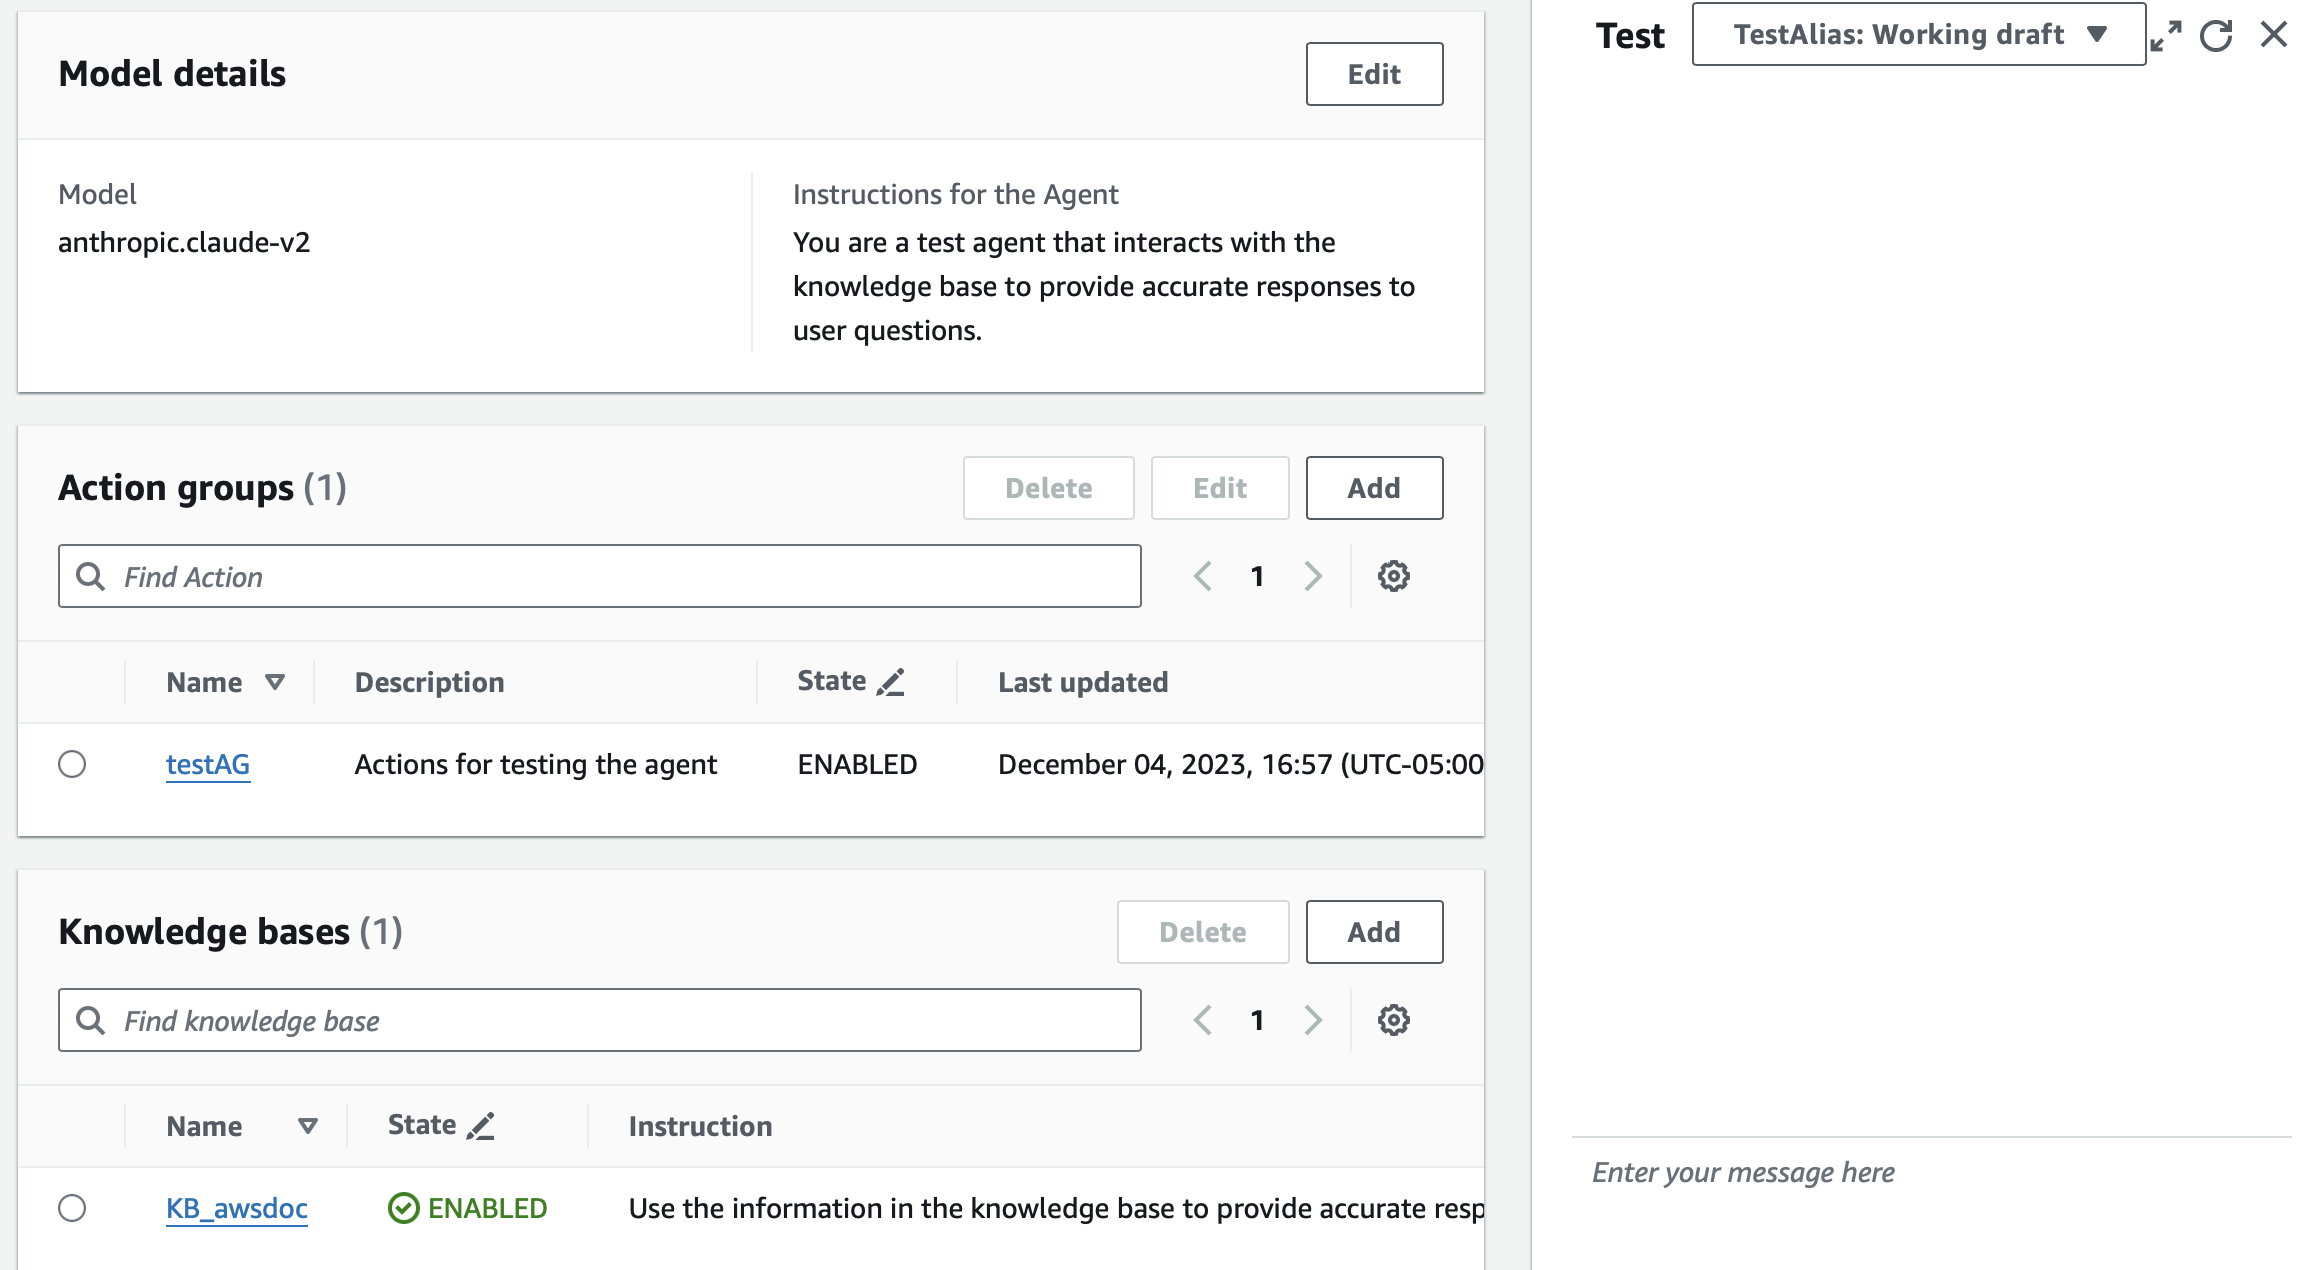

#### Above, we can see how the knowledge base status has changed to enabled. We can use this KB and how it is associated with an agent to invoke the agent and make it query information from the asssociated knowledge base accurately. Let's view an example below.

In [38]:
## create a random id for session initiator id
session_id:str = str(uuid.uuid1())
enable_trace:bool = True

# invoke the agent API
agentResponse = bedrock_agent_client.invoke_agent(inputText="What is Amazon Shield?",
    agentId=agent_id,
    agentAliasId='', ## replace with alias id once the agent is prepared
    sessionId=session_id,
    enableTrace=enable_trace
)

logger.info(pprint.pprint(agentResponse))

[2023-12-04 22:18:22,427] p4194 {796058232.py:13} INFO - None


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-type': 'application/json',
                                      'date': 'Mon, 04 Dec 2023 22:18:22 GMT',
                                      'transfer-encoding': 'chunked',
                                      'x-amz-bedrock-agent-session-id': '0926a24e-92f3-11ee-a2f9-dd7903bce632',
                                      'x-amzn-bedrock-agent-content-type': 'application/json',
                                      'x-amzn-requestid': 'e406c27b-9993-43ed-ad6a-06ee987922a4'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'e406c27b-9993-43ed-ad6a-06ee987922a4',
                      'RetryAttempts': 0},
 'completion': <botocore.eventstream.EventStream object at 0x7f05b5636f20>,
 'contentType': 'application/json',
 'sessionId': '0926a24e-92f3-11ee-a2f9-dd7903bce632'}


## View the response

In [43]:
%%time
import json
event_stream = response['completion']
try:
    for event in event_stream:        
        if 'chunk' in event:
            data = event['chunk']['bytes']
            logger.info(f"Final answer ->\n{data.decode('utf8')}") 
            end_event_received = True
            # End event indicates that the request finished successfully
        elif 'trace' in event:
            logger.info(json.dumps(event['trace'], indent=2))
        else:
            raise Exception("unexpected event.", event)
except Exception as e:
    raise Exception("unexpected event.", e)